In [ ]:
%pip install pmdarima # for auto arima

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from matplotlib.pyplot import figure
from dateutil.relativedelta import relativedelta
from pmdarima.arima import auto_arima

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/My Drive/AI/Alteryx Output.xlsx'
dataset = pd.read_excel(file_path)
dataset.head()

In [46]:
# creating datetime column
dd = dict(year=dataset.INCIDENT_YEAR, month=dataset.INCIDENT_MONTH, day=1)
dataset['date'] = pd.to_datetime(dd)
# dataset.head()

# sorting by date
dataset = dataset.sort_values(by = 'date')

split_date = datetime.datetime(2022,1,1)
last_train_date = split_date - relativedelta(months=1) # previous month

# creating training and validation
test = dataset[dataset['date'] >= split_date]
train = dataset[dataset['date'] < split_date]

In [67]:
# getting unique casern numbers
allcas = dataset['CASERNE'].unique()
allcas = np.sort(allcas)
allcas = [5]

print(allcas)

[5]


In [63]:
def processOneCas(casnum):
  # selecting one caserne
  onecas = train[(train['CASERNE'] == casnum)]
  o = onecas[['date','NUMBER_OF_INCIDENTS']]

  # creating a time series from DataFrame
  s = o.set_index('date')['NUMBER_OF_INCIDENTS']

  # Automatically determine the best ARIMA model
  auto_model = auto_arima(s, seasonal=True, stepwise=True, trace=True, m = 12)
  best_p, best_d, best_q = auto_model.order
  best_P, best_D, best_Q, per = auto_model.seasonal_order

  model = SARIMAX(s, order=(best_p, best_d, best_q),seasonal_order=(best_P,best_D,best_Q,per))
  model_fit = model.fit()

  return s,model_fit


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1181.258, Time=4.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1213.286, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1193.846, Time=0.89 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1198.135, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1506.791, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1192.329, Time=3.51 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1191.957, Time=1.79 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=1186.567, Time=5.11 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1187.051, Time=7.46 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1192.021, Time=0.97 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=1192.755, Time=4.81 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1196.114, Time=4.14 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=8.78 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(2,0,1)(1,0,1)[12] inte

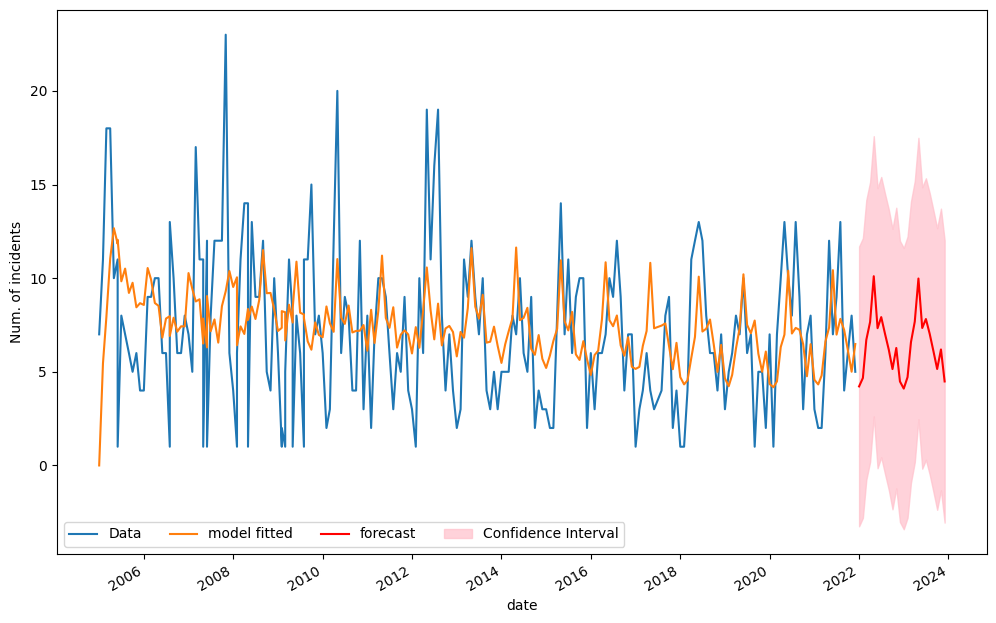

In [68]:
pred_months = 24

for casnum in allcas:
  s,model_fit = processOneCas(casnum)

  ff = model_fit.get_prediction(start=s.shape[0]+1,end=s.shape[0]+pred_months)

  start_date = split_date
  end_date = start_date + relativedelta(months=pred_months-1)

  monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

  fcast = pd.Series(data=ff.predicted_mean.values, index=monthly_dates)
  fcast_conf_int = ff.conf_int()

  figure(figsize=(12, 8))
  s.plot(label = 'Data')
  plt.plot(model_fit.fittedvalues, label = 'model fitted')
  fcast.plot(color = 'red', label = 'forecast')
  plt.fill_between(fcast.index, fcast_conf_int.iloc[:, 0],fcast_conf_int.iloc[:, 1], color='pink', alpha=0.7, label='Confidence Interval')
  plt.ylabel('Num. of incidents')
  plt.legend(loc="lower left", ncol = 4)
